In [1]:
library(Seurat)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(SeuratDisk)
library(RColorBrewer)
library(stringr)
library(patchwork)
library('reshape2')
source("/root/workspace/sjh/code/Compare/MIDAS/utils/utils_process.R")

library("IRdisplay")
display_html("<style>.container { width:100% !important; }</style>")


Attaching SeuratObject

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


T

In [2]:
task <- c("10", "20", "50", "100")
# task <- c("100")
experiment <- c("noise", "subsample", "noise_subsample")
# experiment <- c("H", "H_mask+subsample", "H_mask+noise", "Null model")
inputdir <- "/root/workspace/sjh/data/paper/result"

In [3]:
b_cols <- c("#1B4688", "#CE2725", "#6FAF3C", "#8ABEDE")
c_cols <- c("#7fc97f", "#beaed4", "#fdc086", "#ffff99", "#386cb0")

In [4]:
q <- list()
qpl = 1
for (T in task) {   
    p <- list()
    pl = 1

    config <- parseTOML(pj(inputdir, "../configs/data.toml"))[[paste0("sln_sub", T)]]
    subset_ids <- seq(0, length(config$s_joint)-1)

    labels = data.frame()
    batches = data.frame()
    labels_dir <- pj("/dev/shm/processed/", paste0("sln_sub", T), paste0("subset_", subset_ids), "labels.csv")

    i = 0
    for (l in labels_dir) {
        df <- read.csv(l)
        labels <- rbind(labels, df)
        i_ <- gsub("^0$", "SLN111-D1",
              gsub("^1$", "SLN111-D2",
              gsub("^2$", "SLN208-D1",
              gsub("^3$", "SLN208-D2", i))))
        batches <- rbind(batches, data.frame(batch = rep(i_, nrow(df))))
        i = i + 1
    }

    for (E in experiment) {
        print(E)
        input_dirs <-pj(inputdir, paste0("sln_sub", T), E, "default", "predict", "sp_00000999", paste0("subset_", subset_ids))

        #Load model outputs
        z <- list()
        for (i in subset_ids + 1) {
            z_dir  <- pj(input_dirs[i], "z", "joint")
            fnames <- dir(path = z_dir, pattern = ".csv$")
            fnames <- str_sort(fnames, decreasing = F)
            z_subset <- list()
            for (n in seq_along(fnames)) {
                if (file.exists(file.path(z_dir, fnames[n]))) {
                z_subset[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
                }
            }
            z[[i]] <- bind_rows(z_subset)
        }
        all_z <- data.matrix(bind_rows(z))
        all_c <- all_z[,1:32]
        all_b <- all_z[,33:34]

        rownames(all_c) <- as.character(seq(1, nrow(all_c), 1))
        encoder_c <- CreateSeuratObject(t(all_c))
        encoder_c@meta.data$cell_types <- labels$cell_types
        encoder_c@meta.data$batch <- batches$batch

        encoder_c[['emb']] <- CreateDimReducObject(embeddings = as.matrix(all_c), key = 'emb')
        
        if (ncol(all_c) < 32) {dim_c = ncol(all_c)}
        else {dim_c = 32}
        encoder_c <- RunUMAP(object = encoder_c, reduction = 'emb', dims = 1:dim_c)

        rownames(all_b) <- as.character(seq(1, nrow(all_b), 1))
        encoder_b <- CreateSeuratObject(t(all_b))
        encoder_b@meta.data$cell_types <- labels$cell_types
        encoder_b@meta.data$batch <- batches$batch

        encoder_b[['emb']] <- CreateDimReducObject(embeddings = as.matrix(all_b), key = 'emb')
        encoder_b <- RunUMAP(object = encoder_b, reduction = 'emb', dims = 1:2, metric = "euclidean")

        # c
        # if (pl == 1){
        #     pcc <- DimPlot(encoder_c, group.by = "cell_types", cols = c_cols, pt.size = 0.001) + NoLegend() +
        #                 ylab(paste0("Subset ", T, "%")) + theme(panel.border = element_rect(color = "black", linewidth = 1), 
        #                     axis.title.y = element_text(size = 14, face = "bold"), axis.ticks = element_blank(), axis.text = element_blank(), 
        #                     axis.title.x = element_blank(), plot.margin = margin(0, 0, 0, 0))
        # }
        # else{
            pcc <- DimPlot(encoder_c, group.by = "cell_types", cols = c_cols, pt.size = 0.001, shuffle = TRUE) + NoLegend() + 
                        theme(panel.border = element_rect(color = "black", linewidth = 1), axis.title = element_blank(), 
                            axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 0, 0, 0))
        # }

        # b
        pbc <- DimPlot(encoder_b, group.by = "cell_types", cols = c_cols, pt.size = 0.001, shuffle = TRUE) + 
                    theme(panel.border = element_rect(color = "black", linewidth = 1), axis.title = element_blank(), 
                        axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 10, 0, 0))

        # if (qpl == 1){
        #     pcc <- pcc + ggtitle('latent biological states')
        #     pbc <- pbc + ggtitle('latent technical noise')
        # }
        # else{
            pcc <- pcc + ggtitle('')
            pbc <- pbc + ggtitle('')
        # }

        pcb <- DimPlot(encoder_c, group.by = "batch", cols = b_cols, pt.size = 0.001, shuffle = TRUE) + NoLegend() + 
                    theme(panel.border = element_rect(color = "black", linewidth = 1), , axis.title = element_blank(), 
                    axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 0, 20, 0)) + ggtitle('')
        
        pbb <- DimPlot(encoder_b, group.by = "batch", cols = b_cols, pt.size = 0.001, shuffle = TRUE) + 
                    theme(panel.border = element_rect(color = "black", linewidth = 1), , axis.title = element_blank(), 
                    axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 10, 20, 0)) + ggtitle('')
        
        # if (qpl == 1 & pl == 3){
        #     pbc <- pbc + theme(legend.position = "right", legend.text = element_text(size = 16))
        #     pbb <- pbb + theme(legend.position = "right", legend.text = element_text(size = 16))
        # }
        # else{
            pbc <- pbc +  NoLegend()
            pbb <- pbb + NoLegend()
        # }

        p[[pl]] <- (pcc | pbc) / (pcb | pbb) + plot_layout(ncol = 1, heights = c(1, 1))
        # p[[pl]] <- pcc / pcb + plot_layout(ncol = 1, heights = c(1, 1))
        pl = pl + 1      
    }

    q[[qpl]]  <- p[[1]] | p[[2]] | p[[3]]
    qpl = qpl + 1
}

[1] "noise"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
02:20:30 UMAP embedding parameters a = 0.9922 b = 1.112

02:20:30 Read 2924 rows and found 32 numeric columns

02:20:30 Using Annoy for neighbor search, n_neighbors = 30

02:20:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

[1] "subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:20:42 UMAP embedding parameters a = 0.9922 b = 1.112

02:20:42 Read 2924 rows and found 32 numeric columns

02:20:42 Using Annoy for neighbor search, n_neighbors = 30

02:20:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:20:42 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf4c4e52f2

02:20:42 Searching Annoy index using 1 thread, search_k = 3000

02:20:43 Annoy recall = 100%

02:20:44 Commencing smooth kNN distance calibration usin

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:20:53 UMAP embedding parameters a = 0.9922 b = 1.112

02:20:53 Read 2924 rows and found 32 numeric columns

02:20:53 Using Annoy for neighbor search, n_neighbors = 30

02:20:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:20:54 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf64a3eb29

02:20:54 Searching Annoy index using 1 thread, search_k = 3000

02:20:55 Annoy recall = 100%

02:20:55 Commencing smooth kNN distance calibration usin

[1] "noise"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:21:05 UMAP embedding parameters a = 0.9922 b = 1.112

02:21:05 Read 5859 rows and found 32 numeric columns

02:21:05 Using Annoy for neighbor search, n_neighbors = 30

02:21:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:21:06 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf3a323c3c

02:21:06 Searching Annoy index using 1 thread, search_k = 3000

02:21:07 Annoy recall = 100%

02:21:08 Commencing smooth kNN distance calibration usin

[1] "subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:21:28 UMAP embedding parameters a = 0.9922 b = 1.112

02:21:28 Read 5859 rows and found 32 numeric columns

02:21:28 Using Annoy for neighbor search, n_neighbors = 30

02:21:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:21:28 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf15ac3ebb

02:21:28 Searching Annoy index using 1 thread, search_k = 3000

02:21:30 Annoy recall = 100%

02:21:30 Commencing smooth kNN distance calibration usin

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:21:50 UMAP embedding parameters a = 0.9922 b = 1.112

02:21:50 Read 5859 rows and found 32 numeric columns

02:21:50 Using Annoy for neighbor search, n_neighbors = 30

02:21:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:21:51 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf14474594

02:21:51 Searching Annoy index using 1 thread, search_k = 3000

02:21:53 Annoy recall = 100%

02:21:54 Commencing smooth kNN distance calibration usin

[1] "noise"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:22:15 UMAP embedding parameters a = 0.9922 b = 1.112

02:22:15 Read 14664 rows and found 32 numeric columns

02:22:15 Using Annoy for neighbor search, n_neighbors = 30

02:22:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:22:16 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bfb70ceea

02:22:16 Searching Annoy index using 1 thread, search_k = 3000

02:22:20 Annoy recall = 100%

02:22:21 Commencing smooth kNN distance calibration usin

[1] "subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:22:47 UMAP embedding parameters a = 0.9922 b = 1.112

02:22:47 Read 14664 rows and found 32 numeric columns

02:22:47 Using Annoy for neighbor search, n_neighbors = 30

02:22:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:22:48 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf2a11c7c6

02:22:48 Searching Annoy index using 1 thread, search_k = 3000

02:22:53 Annoy recall = 100%

02:22:53 Commencing smooth kNN distance calibration usi

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:23:19 UMAP embedding parameters a = 0.9922 b = 1.112

02:23:19 Read 14664 rows and found 32 numeric columns

02:23:19 Using Annoy for neighbor search, n_neighbors = 30

02:23:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:23:20 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf8fb625e

02:23:20 Searching Annoy index using 1 thread, search_k = 3000

02:23:25 Annoy recall = 100%

02:23:25 Commencing smooth kNN distance calibration usin

[1] "noise"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:23:54 UMAP embedding parameters a = 0.9922 b = 1.112

02:23:54 Read 29338 rows and found 32 numeric columns

02:23:54 Using Annoy for neighbor search, n_neighbors = 30

02:23:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:23:57 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf1dad4f19

02:23:57 Searching Annoy index using 1 thread, search_k = 3000

02:24:06 Annoy recall = 100%

02:24:07 Commencing smooth kNN distance calibration usi

[1] "subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:24:58 UMAP embedding parameters a = 0.9922 b = 1.112

02:24:58 Read 29338 rows and found 32 numeric columns

02:24:58 Using Annoy for neighbor search, n_neighbors = 30

02:24:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:25:01 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf6553e0fe

02:25:01 Searching Annoy index using 1 thread, search_k = 3000

02:25:10 Annoy recall = 100%

02:25:11 Commencing smooth kNN distance calibration usi

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
02:26:00 UMAP embedding parameters a = 0.9922 b = 1.112

02:26:00 Read 29338 rows and found 32 numeric columns

02:26:00 Using Annoy for neighbor search, n_neighbors = 30

02:26:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:26:03 Writing NN index file to temp file /tmp/RtmpV9nUTw/file86bf561d6bbb

02:26:03 Searching Annoy index using 1 thread, search_k = 3000

02:26:12 Annoy recall = 100%

02:26:13 Commencing smooth kNN distance calibration usi

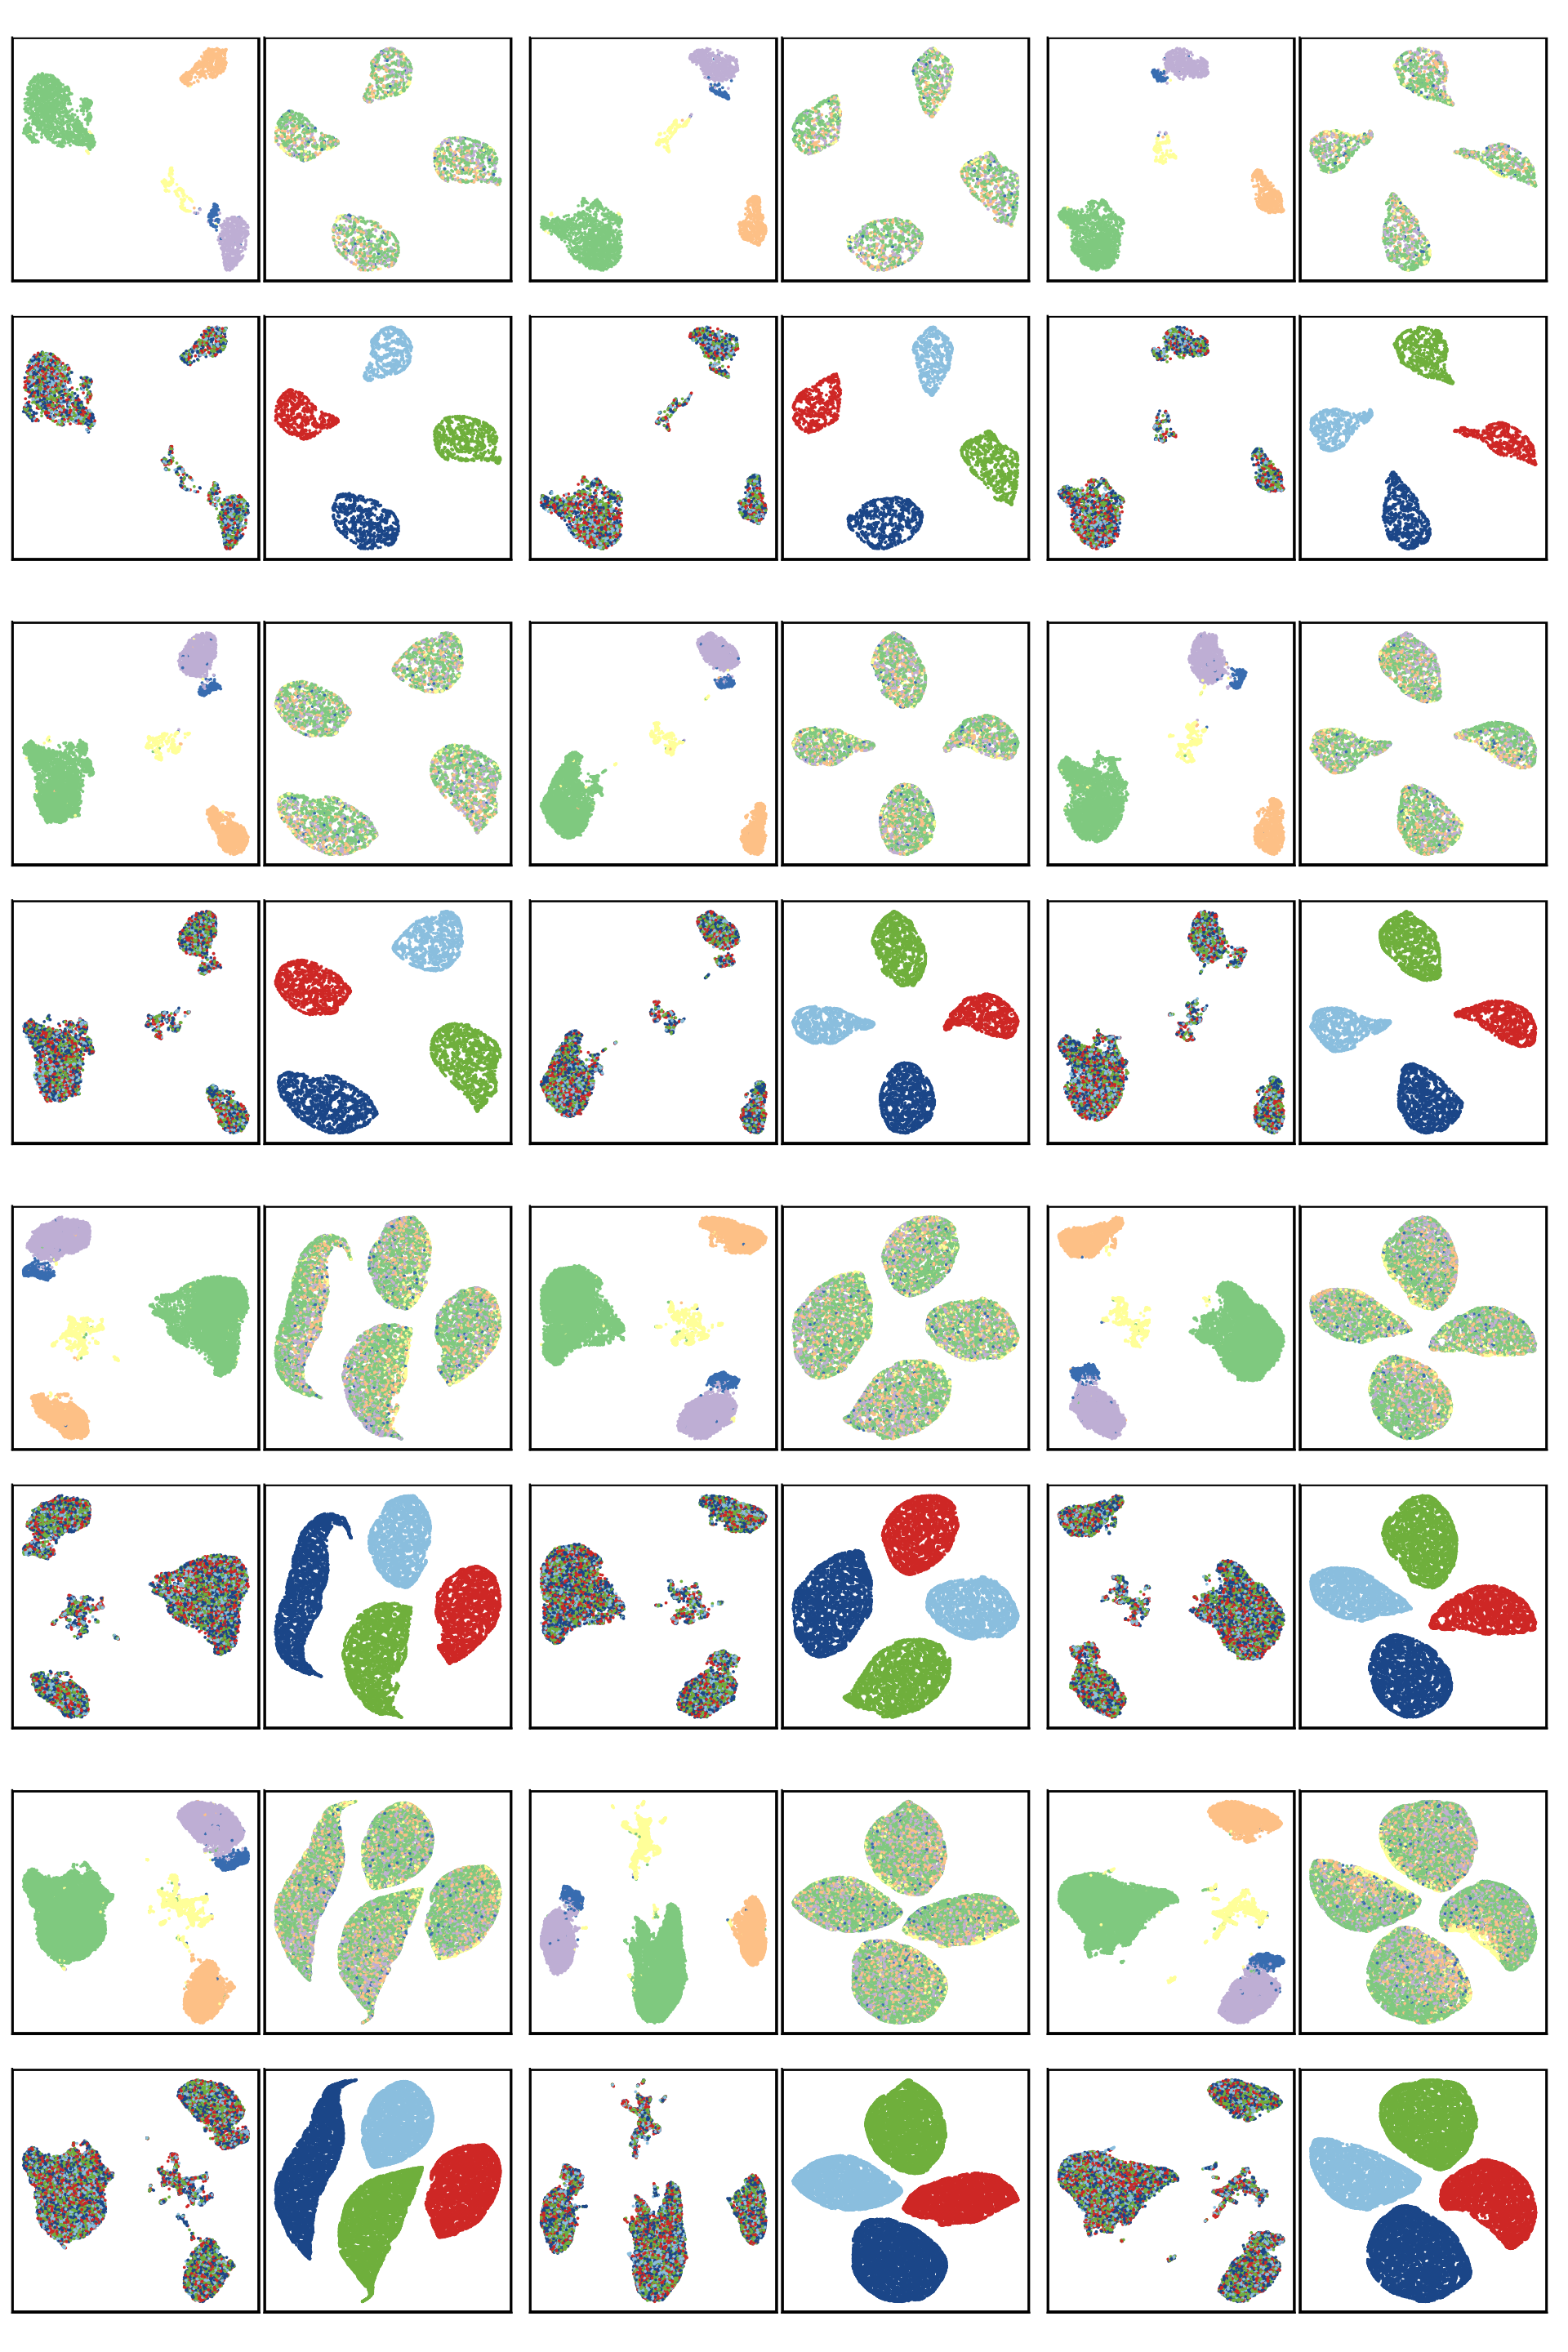

In [5]:
options(repr.plot.width = 16, repr.plot.height = 24)
Q <- q[[1]] / q[[2]] / q[[3]] / q[[4]]
# options(repr.plot.width = 8, repr.plot.height = 6)
# Q <- q[[1]]
Q

In [6]:
# ggsave("figure4.png", Q, dpi = 300, width = 16, height = 24)